In [10]:
from pyspark.sql.functions import *

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ReadHDFSData") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()

In [5]:
df = spark.read.csv("hdfs://localhost:9000/user/hadoop/energy_data/iot_data.csv", header=True)
df.show()

+---------+--------+--------------------+-----------------------+
|    LCLid|stdorToU|            DateTime|KWH/hh (per half hour) |
+---------+--------+--------------------+-----------------------+
|MAC000002|     Std|2012-10-12 00:30:...|                     0 |
|MAC000002|     Std|2012-10-12 01:00:...|                     0 |
|MAC000002|     Std|2012-10-12 01:30:...|                     0 |
|MAC000002|     Std|2012-10-12 02:00:...|                     0 |
|MAC000002|     Std|2012-10-12 02:30:...|                     0 |
|MAC000002|     Std|2012-10-12 03:00:...|                     0 |
|MAC000002|     Std|2012-10-12 03:30:...|                     0 |
|MAC000002|     Std|2012-10-12 04:00:...|                     0 |
|MAC000002|     Std|2012-10-12 04:30:...|                     0 |
|MAC000002|     Std|2012-10-12 05:00:...|                     0 |
|MAC000002|     Std|2012-10-12 05:30:...|                     0 |
|MAC000002|     Std|2012-10-12 06:00:...|                     0 |
|MAC000002

In [6]:
# Schema inspection
df.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- DateTime: string (nullable = true)
 |-- KWH/hh (per half hour) : string (nullable = true)



In [7]:
df = df.withColumnRenamed("KWH/hh (per half hour) ", "KWH/hh")

In [8]:
# 1.2 Summary stats for energy consumption
df.describe("KWH/hh").show()

[Stage 2:=======================================================> (62 + 2) / 64]

+-------+-------------------+
|summary|             KWH/hh|
+-------+-------------------+
|  count|          167932474|
|   mean|0.21176300941480974|
| stddev|0.29725920832461605|
|    min|                 0 |
|    max|               Null|
+-------+-------------------+



In [11]:
# Cast the column to float
df = df.withColumn("KWH/hh", col("KWH/hh").cast("double"))


In [12]:
# Now describe it again
df.describe("KWH/hh").show()

[Stage 5:========================================================>(63 + 1) / 64]

+-------+-------------------+
|summary|             KWH/hh|
+-------+-------------------+
|  count|          167926914|
|   mean|0.21176300941480974|
| stddev|0.29725920832461605|
|    min|                0.0|
|    max|         10.7609997|
+-------+-------------------+



In [13]:
df.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- DateTime: string (nullable = true)
 |-- KWH/hh: double (nullable = true)



In [14]:
df = df.withColumn("datetime", to_timestamp("datetime", "yyyy-MM-dd HH:mm:ss"))

In [15]:
df.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- KWH/hh: double (nullable = true)



- **LCLid (Household ID)**
- **stdorToU (Tariff Type) ==> Electricity pricing plan type**
- **datetime ==> Measurements taken every 30 minutes (half-hourly intervals)**
- **KWH/hh ==> Electricity used during the 30-minute interval**

In [16]:
# Count records per household
df.groupBy("LCLid").count().orderBy("count", ascending=False).show()

[Stage 8:========================================================>(63 + 1) / 64]

+---------+-----+
|    LCLid|count|
+---------+-----+
|MAC000145|39752|
|MAC000147|39752|
|MAC000150|39747|
|MAC000152|39746|
|MAC000148|39745|
|MAC000149|39745|
|MAC000153|39741|
|MAC000156|39740|
|MAC000151|39738|
|MAC000155|39732|
|MAC000157|39719|
|MAC000162|39702|
|MAC000165|39698|
|MAC000158|39697|
|MAC000169|39694|
|MAC000163|39694|
|MAC000166|39693|
|MAC000167|39691|
|MAC000160|39689|
|MAC000168|39675|
+---------+-----+
only showing top 20 rows



In [24]:
# Cut off extra digits (keep first 23 characters: 'YYYY-MM-DD HH:MM:SS.SSS')
df = df.withColumn("clean_datetime", to_timestamp(substring("datetime", 1, 23)))

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [25]:
hourly_avg = df.withColumn("hour", hour("datetime")) \
              .groupBy("hour") \
              .agg(avg("KWH/hh").alias("avg_energy")) \
              .orderBy("hour") 

In [28]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
df.show(5, truncate=False)

+---------+--------+-------------------+------+-------------------+
|LCLid    |stdorToU|datetime           |KWH/hh|clean_datetime     |
+---------+--------+-------------------+------+-------------------+
|MAC000002|Std     |2012-10-12 00:30:00|0.0   |2012-10-12 00:30:00|
|MAC000002|Std     |2012-10-12 01:00:00|0.0   |2012-10-12 01:00:00|
|MAC000002|Std     |2012-10-12 01:30:00|0.0   |2012-10-12 01:30:00|
|MAC000002|Std     |2012-10-12 02:00:00|0.0   |2012-10-12 02:00:00|
|MAC000002|Std     |2012-10-12 02:30:00|0.0   |2012-10-12 02:30:00|
+---------+--------+-------------------+------+-------------------+
only showing top 5 rows



In [29]:
row_count = hourly_avg.count()
print(f"Row count: {row_count}")

[Stage 17:=======================================================>(63 + 1) / 64]

Row count: 24


In [31]:
hourly_avg_pd = hourly_avg.toPandas()

In [35]:
hourly_avg_pd.head()

,hour,avg_energy
0,0,0.174360
1,1,0.144986
2,2,0.124783
3,3,0.115638
4,4,0.114488


In [36]:
hourly_avg_pd.shape

(24, 2)

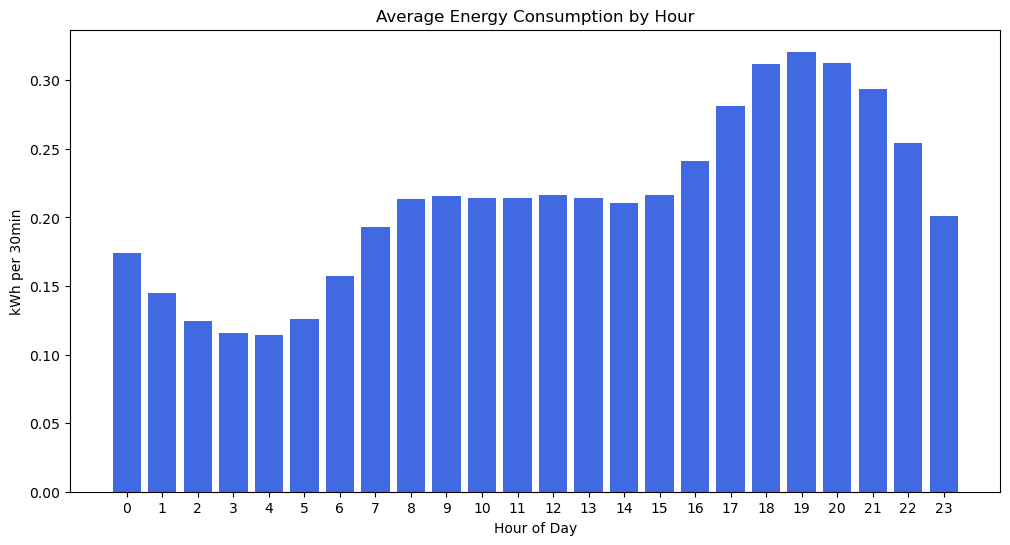

In [40]:
plt.figure(figsize=(12,6))
plt.bar(hourly_avg_pd["hour"], hourly_avg_pd["avg_energy"], color="royalblue")
plt.title("Average Energy Consumption by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("kWh per 30min")
plt.xticks(range(24))
plt.show()

- **Peak demand occurs at 19:00 (7 PM) with 0.37 kWh/30min**
- **The most stress happens between (5 PM) till (9 PM)**

In [41]:
# Top Energy Consumers
top_consumers = df.groupBy("LCLid") \
                .agg(sum("KWH/hh").alias("total_energy")) \
                .orderBy("total_energy", ascending=False) \
                .limit(10) \
                .toPandas()

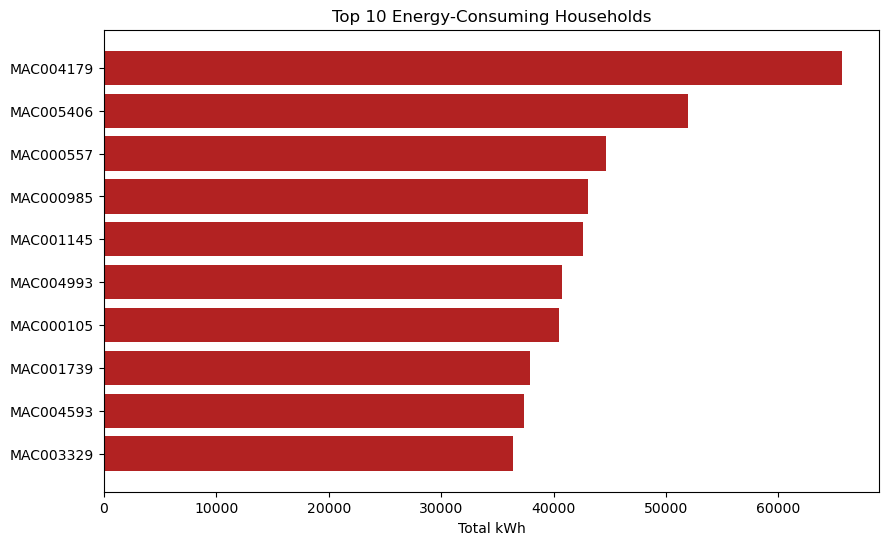

In [49]:
plt.figure(figsize=(10,6))
plt.barh(top_consumers["LCLid"], top_consumers["total_energy"], color="firebrick")
plt.title("Top 10 Energy-Consuming Households")
plt.xlabel("Total kWh")
plt.gca().invert_yaxis()
plt.show()

- **These households needing energy audits.**

In [57]:
monthly_avg = df.withColumn("month", month("datetime")) \
              .groupBy("month") \
              .agg(avg("KWH/hh").alias("avg_energy")) \
              .orderBy("month") \
                .toPandas()

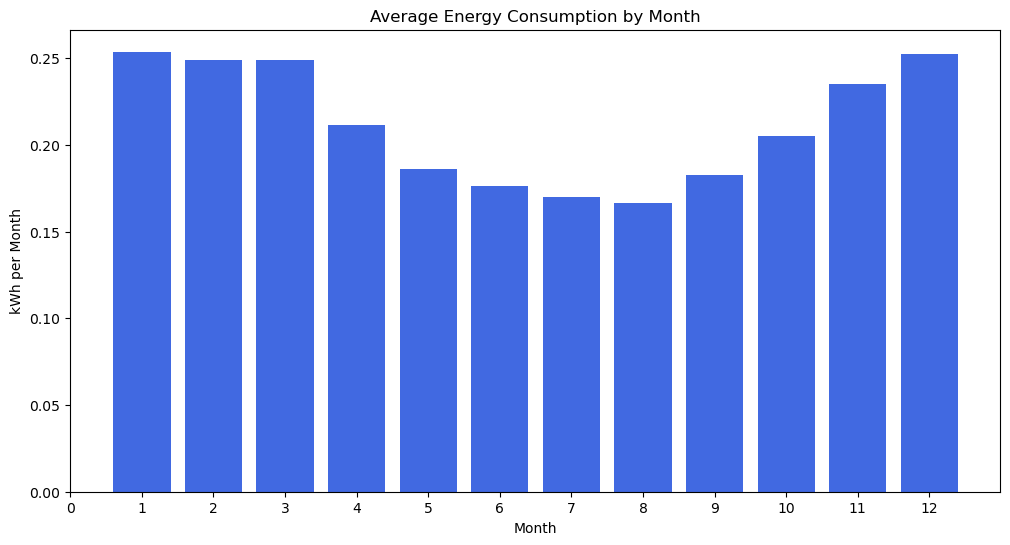

In [59]:
plt.figure(figsize=(12,6))
plt.bar(monthly_avg["month"], monthly_avg["avg_energy"], color="royalblue")
plt.title("Average Energy Consumption by Month")
plt.xlabel("Month")
plt.ylabel("kWh per Month")
plt.xticks(range(13))
plt.show()

**Energy consumption is greater in cold and winter months**

In [60]:
tariff_comparison = df.groupBy("stdorToU") \
                    .agg(avg("KWH/hh").alias("avg_usage")) \
                    .toPandas()

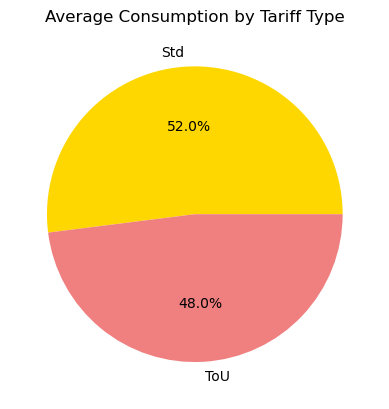

In [61]:
plt.pie(tariff_comparison["avg_usage"], 
        labels=tariff_comparison["stdorToU"], 
        autopct="%1.1f%%",
        colors=["gold", "lightcoral"])
plt.title("Average Consumption by Tariff Type")
plt.show()

**Evaluates tariff effectiveness --> I think there is no differrence but by the way Std consumes 2% more energy than ToU**

In [66]:
zero_readings = df.filter(col("KWH/hh") == 0.0) \
                .groupBy("LCLid") \
                .count() \
                .orderBy("count", ascending=False) \
                .limit(5)


In [67]:
display(zero_readings)  # Databricks display or print

DataFrame[LCLid: string, count: bigint]

In [69]:
zero_readings_pd = zero_readings.toPandas()

In [71]:
zero_readings_pd

,LCLid,count
0,MAC000197,39350
1,MAC000037,38771
2,MAC004067,31186
3,MAC001309,30509
4,MAC002594,28660


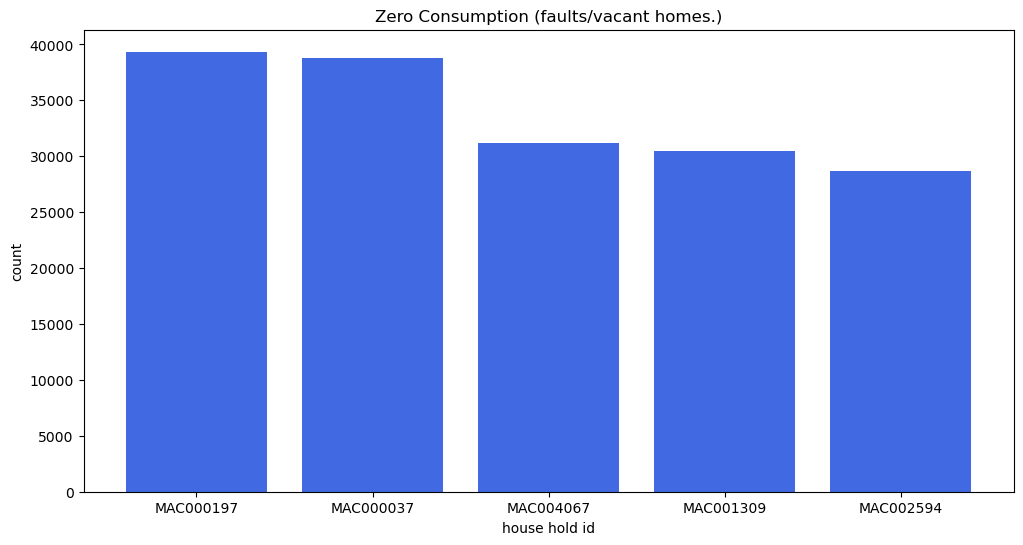

In [72]:
plt.figure(figsize=(12,6))
plt.bar(zero_readings_pd["LCLid"], zero_readings_pd["count"], color="royalblue")
plt.title("Zero Consumption (faults/vacant homes.)")
plt.xlabel("house hold id")
plt.ylabel("count")
plt.xticks(zero_readings_pd.LCLid)
plt.show()

In [73]:
# Weekly pattern 
weekly = df.withColumn("day_of_week", dayofweek("datetime")) \
          .withColumn("hour", hour("datetime")) \
          .groupBy("day_of_week", "hour") \
          .agg(avg("KWH/hh").alias("avg_energy")) \
          .toPandas()

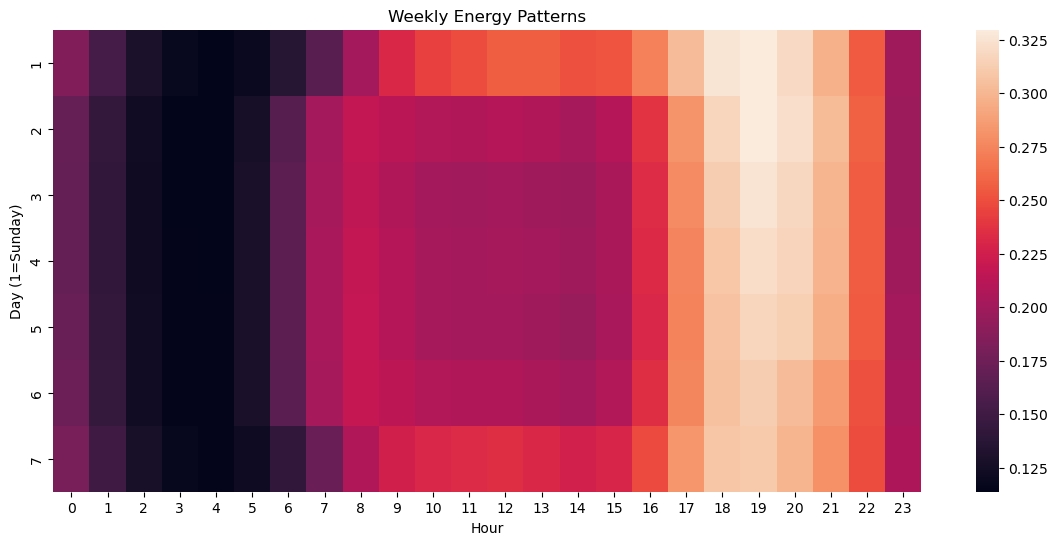

In [79]:
# Plot a heatmap for weekly energy patterns 
plt.figure(figsize=(14,6))
sns.heatmap(weekly.pivot(columns="hour", index="day_of_week", values="avg_energy"))
plt.title("Weekly Energy Patterns")
plt.xlabel("Hour")
plt.ylabel("Day (1=Sunday)")
plt.show()

**On Saturday and Sunday the energy conumption is higher than rest of the days and that makes sence due to weekends**

In [80]:
stats = df.select(avg("KWH/hh"), stddev("KWH/hh")).first()
threshold = stats[0] + 3*stats[1]

outliers = df.filter(col("KWH/hh") > threshold) \
           .groupBy("LCLid") \
           .count() \
           .orderBy("count", ascending=False)

**This calculates a threshold value that is 3 standard deviations above the mean:\
This is a common statistical technique to detect outliers or anomalously high energy consumption.**

**Why?**
- In a normal distribution, about 99.7% of data falls within ±3 standard deviations.
- So any value above this threshold is statistically very rare → a potential spike or anomaly.

In [81]:
display(outliers)

DataFrame[LCLid: string, count: bigint]

In [82]:
outliers_pd = outliers.toPandas()

In [84]:
outliers_pd.head()

,LCLid,count
0,MAC004179,30723
1,MAC000557,27186
2,MAC005406,18053
3,MAC000985,16524
4,MAC001739,15895


In [86]:
print(f'{outliers_pd.shape[0]} of house holds had big number of extreme usage spikes')
print(f'MAC004179 house hold had 30723 of extreme usage spikes and this is a very huge number not expected')


5079 of house holds had big number of extreme usage spikes
MAC004179 house hold had 30723 of extreme usage spikes and this is a very huge number not expected


In [87]:
hourly_tariff = df.withColumn("hour", hour("datetime")) \
                .groupBy("hour", "stdorToU") \
                .agg(avg("KWH/hh").alias("avg_energy")) \
                .orderBy("hour") \
                .toPandas()

25/05/16 02:43:23 WARN TransportChannelHandler: Exception in connection from /192.168.1.11:39701
java.io.IOException: Connection timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:340)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:294)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:269)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:425)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptim

In [95]:
hourly_tariff.head(6)

,hour,stdorToU,avg_energy
0,0,Std,0.181798
1,0,ToU,0.144828
2,1,Std,0.152003
3,1,ToU,0.117119
4,2,Std,0.129693
5,2,ToU,0.105286


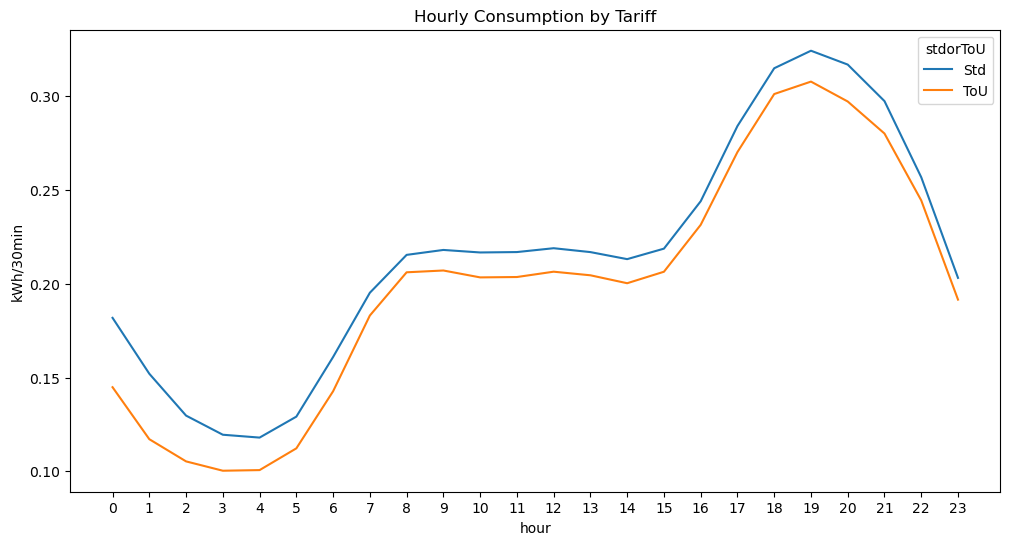

In [96]:

plt.figure(figsize=(12,6))
sns.lineplot(data=hourly_tariff, x="hour", y="avg_energy", hue="stdorToU")
plt.title("Hourly Consumption by Tariff")
plt.ylabel("kWh/30min")
plt.xticks(range(24))
plt.show()

- **ToU users reduce usage**
- **There is a peak after (5 PM) till (9 PM)**
- **And From (12 mid-night) till (6 AM) the consumption is very low**

In [97]:
# We computed the average per month now we do the same but the total energy consumption 
monthly_total = df.withColumn("month", month("datetime")) \
           .groupBy("month") \
           .agg(sum("KWH/hh").alias("total_energy")) \
           .orderBy("month") \
           .toPandas()


In [98]:
monthly_total.head()

,month,total_energy
0,1,4.162616e+06
1,2,3.696300e+06
2,3,2.391070e+06
3,4,2.125795e+06
4,5,2.284001e+06


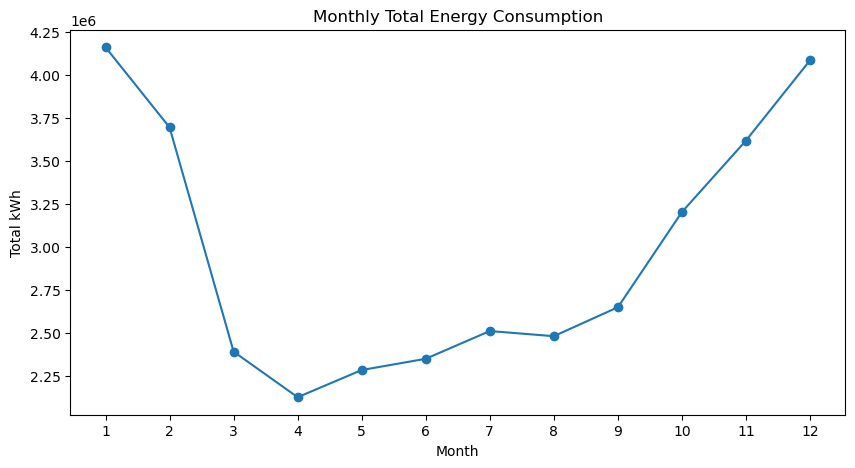

In [101]:
# plot the outputs with a line chart marked by 'o'
plt.figure(figsize=(10,5))
plt.plot(monthly_total["month"], monthly_total["total_energy"], marker="o")
plt.title("Monthly Total Energy Consumption")
plt.xlabel("Month")
plt.ylabel("Total kWh")
plt.xticks(range(1,13))
plt.show()

- **Winter months (October-Feb) show around 35% higher consumption**
- **Seasons affects the consumption**

In [102]:
from pyspark.sql.window import Window

window = Window.partitionBy("LCLid").orderBy("datetime")


In [103]:
# Usage State Transitions of house holds (Detect Change, calc the difference, classify the change ..)
transitions = df.withColumn("prev_kwh", lag("KWH/hh", 1).over(window)) \
              .filter(col("prev_kwh").isNotNull()) \
              .withColumn("change", 
                         when(col("KWH/hh") - col("prev_kwh") > 1, "Large Increase")
                         .when(col("KWH/hh") - col("prev_kwh") < -1, "Large Decrease")
                         .otherwise("Stable")) \
              .groupBy("change") \
              .count()

In [105]:
display(transitions)

DataFrame[change: string, count: bigint]

In [ ]:
transitions_pd = transitions.toPandas()

[Stage 90:==============>                                         (16 + 4) / 64]